<a href="https://colab.research.google.com/github/thaivu4122/snake-stm32/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_BTL_De_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Đã tạo 100 nút.
-> Đã xuất tọa độ ra file: phu_luc_toa_do.txt

--- CÂU 1 ---
Cost Câu 1: 1718


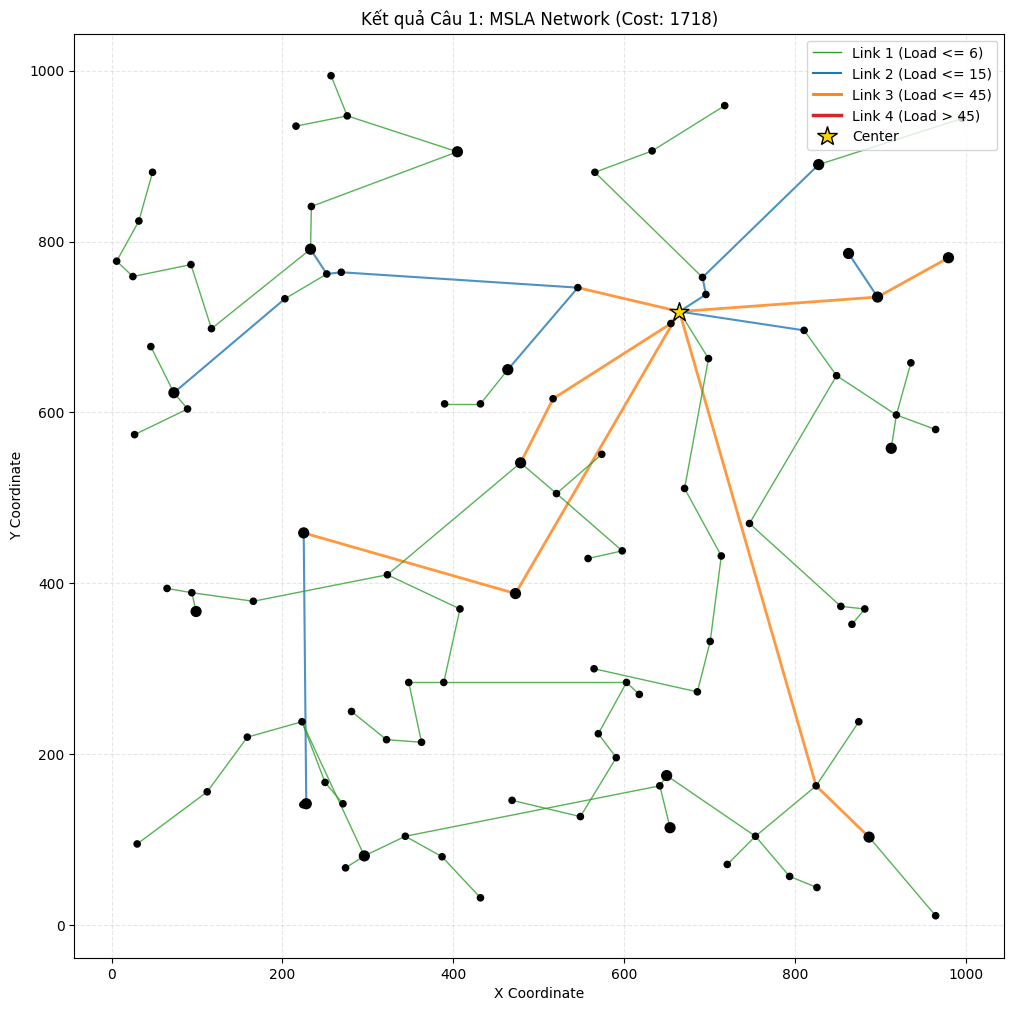


--- CÂU 2 ---
Cost Câu 2: 1580


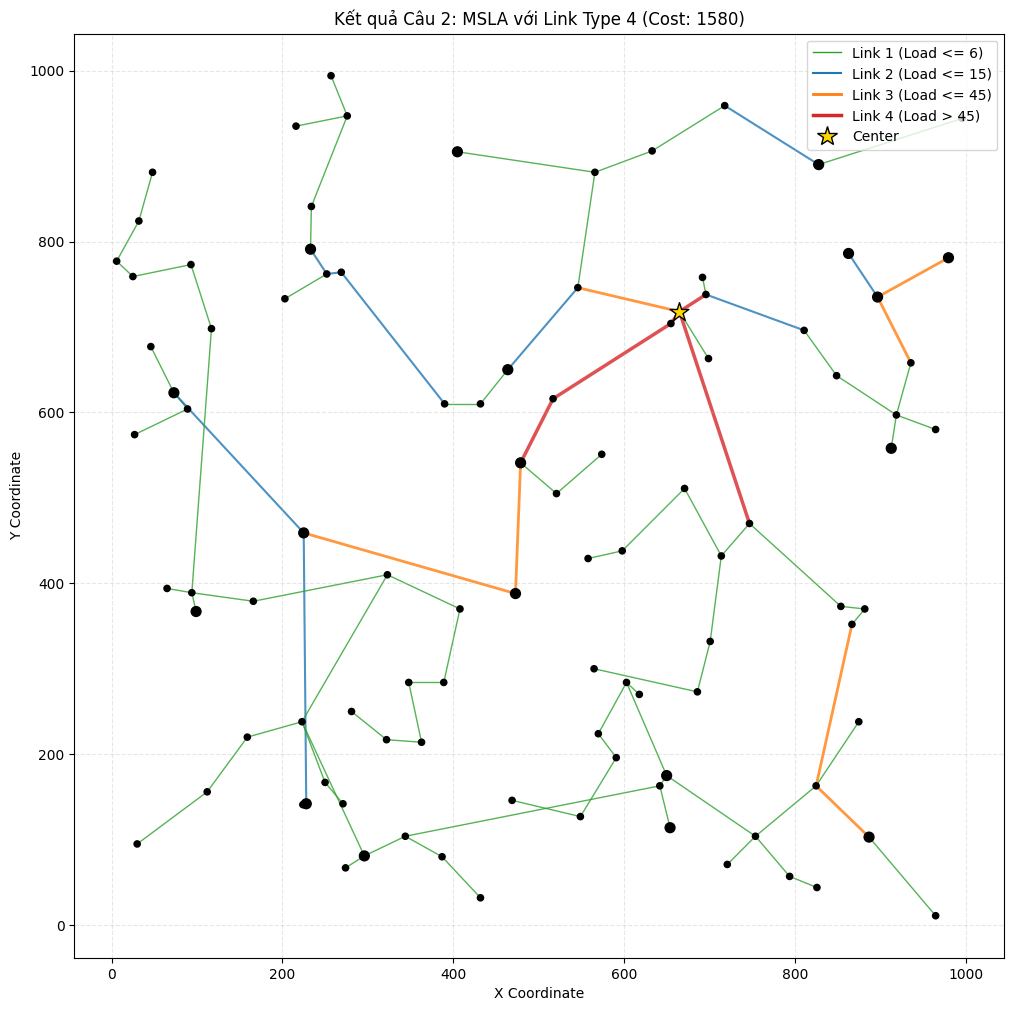


--- CÂU 3 ---
Cost Câu 3: 2121


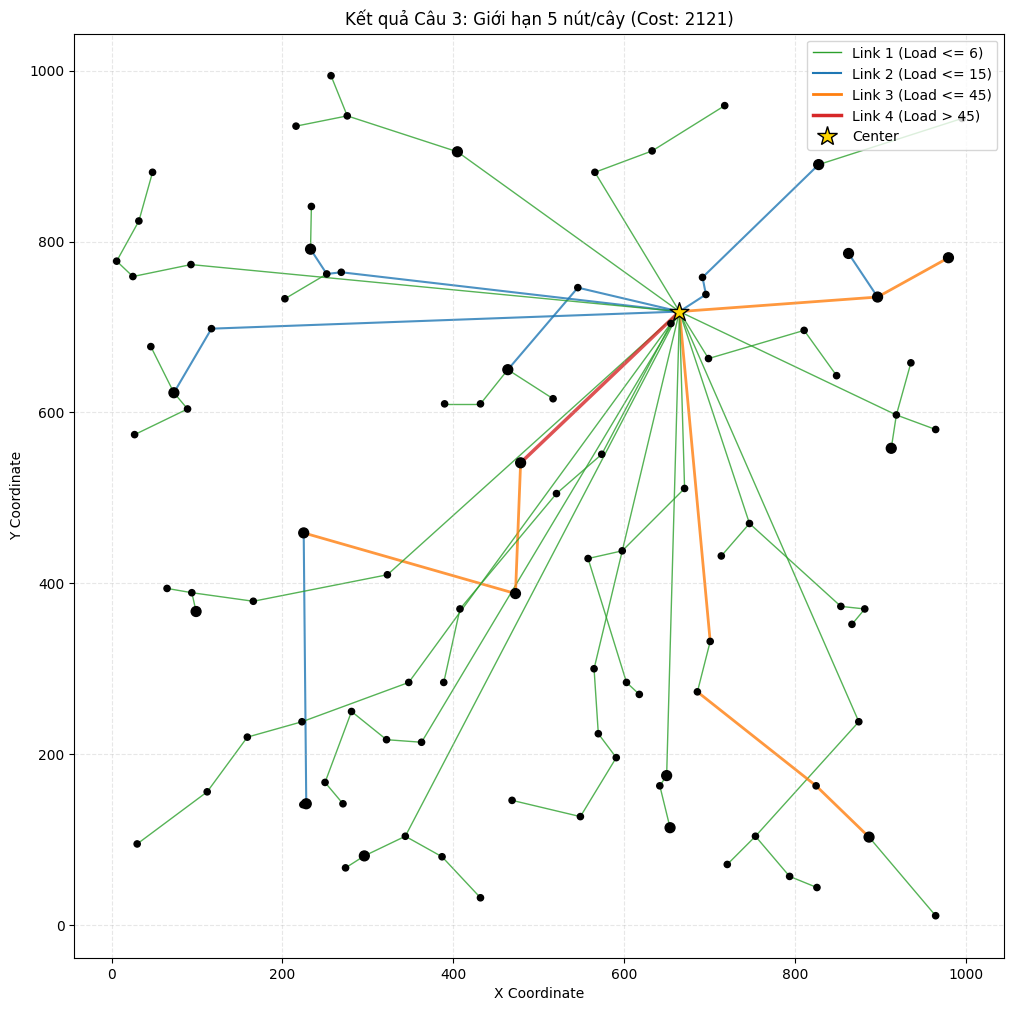

In [1]:
import math
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Dùng để tạo chú thích (Legend) tùy chỉnh

# --- CẤU HÌNH ---
NUM_NODES = 100
MAP_SIZE = 1000
CENTER_ID = 15
OUTPUT_FILE = "ket_qua_mang.txt"
COORD_FILE = "phu_luc_toa_do.txt"

# Cấu hình trọng số (Lưu lượng)
def get_node_weight(node_id):
    if node_id in [1, 28, 44]: return 2
    if node_id in [19, 48, 64]: return 7
    if node_id in [17, 25, 59]: return 18
    if node_id in [4, 43, 55]: return 8
    if node_id in [7, 56, 75]: return 3
    if node_id in [72, 46, 95]: return 20
    if node_id == CENTER_ID: return 0
    return 1

# --- LỚP ĐỐI TƯỢNG NÚT ---
class Node:
    def __init__(self, id, x, y, weight):
        self.id = id
        self.x = x
        self.y = y
        self.weight = weight
        self.subtree_load = weight
        self.parent = None
        self.children = []

def dist(n1, n2):
    return math.sqrt((n1.x - n2.x)**2 + (n1.y - n2.y)**2)

# --- HÀM TÍNH GIÁ LIÊN KẾT ---
def get_link_cost(distance, load, use_link_4=False):
    cost = float('inf')
    if load <= 6:
        cost = round(0.1 * distance)
    elif load <= 15:
        cost = round(0.2 * distance)
    elif load <= 45:
        cost = round(0.4 * distance)
    elif use_link_4 and load <= 80:
        cost = round(0.6 * distance)
    return cost

# --- THUẬT TOÁN ESAU-WILLIAMS ---
def solve_msla(nodes_dict, use_link_4=False, max_nodes_limit=None):
    center = nodes_dict[CENTER_ID]
    clusters = {}

    # Reset trạng thái
    for nid, node in nodes_dict.items():
        if nid != CENTER_ID:
            node.parent = center
            node.children = []
            node.subtree_load = node.weight
            clusters[nid] = [node]

    center.children = [n for nid, n in nodes_dict.items() if nid != CENTER_ID]

    while True:
        best_tradeoff = -float('inf')
        best_merge = None

        cluster_roots = list(clusters.keys())

        for i_id in cluster_roots:
            root_i = nodes_dict[i_id]
            dist_i_center = dist(root_i, center)
            cost_i_center = get_link_cost(dist_i_center, root_i.subtree_load, use_link_4)
            if cost_i_center == float('inf'): continue

            for j_id in nodes_dict:
                if i_id == j_id or j_id == CENTER_ID: continue

                # Tìm root của j
                j_root_id = None
                for rid, members in clusters.items():
                    if nodes_dict[j_id] in members:
                        j_root_id = rid
                        break

                if i_id == j_root_id: continue

                node_j = nodes_dict[j_id]
                root_j = nodes_dict[j_root_id]

                new_load = root_i.subtree_load + root_j.subtree_load

                # Kiểm tra giới hạn số nút (Câu 3)
                if max_nodes_limit:
                    total_nodes = len(clusters[i_id]) + len(clusters[j_root_id])
                    if total_nodes > max_nodes_limit:
                        continue

                d_ij = dist(root_i, node_j)
                dist_j_center = dist(root_j, center)

                cost_merged_center = get_link_cost(dist_j_center, new_load, use_link_4)
                cost_link_ij = get_link_cost(d_ij, root_i.subtree_load, use_link_4)

                if cost_merged_center == float('inf') or cost_link_ij == float('inf'):
                    continue

                current_cost = get_link_cost(dist_i_center, root_i.subtree_load, use_link_4) + \
                               get_link_cost(dist_j_center, root_j.subtree_load, use_link_4)
                new_total_cost = cost_link_ij + cost_merged_center

                saving = current_cost - new_total_cost

                if saving > 0 and saving > best_tradeoff:
                    best_tradeoff = saving
                    best_merge = (i_id, j_id, j_root_id)

        if best_merge:
            i_id, j_id, j_root_id = best_merge
            node_i = nodes_dict[i_id]
            node_j = nodes_dict[j_id]

            node_i.parent = node_j
            node_j.children.append(node_i)

            root_j = nodes_dict[j_root_id]
            root_j.subtree_load += node_i.subtree_load

            clusters[j_root_id].extend(clusters[i_id])
            del clusters[i_id]

            if node_i in center.children:
                center.children.remove(node_i)
        else:
            break

    return clusters

def calculate_total_network_cost(nodes_dict, use_link_4=False):
    total_cost = 0
    for nid, node in nodes_dict.items():
        if nid == CENTER_ID: continue
        parent = node.parent
        if parent:
            d = dist(node, parent)
            c = get_link_cost(d, node.subtree_load, use_link_4)
            total_cost += c
    return total_cost

# --- HÀM XUẤT TỌA ĐỘ ---
def export_node_data(nodes_dict):
    with open(COORD_FILE, "w", encoding="utf-8") as f:
        f.write("PHỤ LỤC: DANH SÁCH TỌA ĐỘ VÀ TRỌNG SỐ CÁC NÚT\n")
        f.write("="*60 + "\n")
        f.write(f"{'ID':<5} | {'Tọa độ X':<10} | {'Tọa độ Y':<10} | {'Lưu lượng':<10}\n")
        f.write("-" * 60 + "\n")
        for nid in sorted(nodes_dict.keys()):
            n = nodes_dict[nid]
            f.write(f"{nid:<5} | {n.x:<10} | {n.y:<10} | {n.weight:<10}\n")
    print(f"-> Đã xuất tọa độ ra file: {COORD_FILE}")

# --- HÀM VẼ MẠNG (CẬP NHẬT MÀU SẮC) ---
def draw_network(nodes_dict, title):
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Vẽ các liên kết
    for nid, node in nodes_dict.items():
        if nid != CENTER_ID and node.parent:
            # Chọn màu dựa trên tải
            load = node.subtree_load
            color = 'gray'
            width = 1.0

            if load <= 6:
                color = '#2ca02c' # Green (Type 1)
                width = 1.0
            elif load <= 15:
                color = '#1f77b4' # Blue (Type 2)
                width = 1.5
            elif load <= 45:
                color = '#ff7f0e' # Orange (Type 3)
                width = 2.0
            else:
                color = '#d62728' # Red (Type 4)
                width = 2.5

            plt.plot([node.x, node.parent.x], [node.y, node.parent.y], color=color, linewidth=width, alpha=0.8, zorder=1)

    # Vẽ các nút
    xs = [n.x for n in nodes_dict.values()]
    ys = [n.y for n in nodes_dict.values()]
    # Kích thước nút dựa trên trọng số riêng (cho đẹp)
    sizes = [50 if n.weight > 1 else 20 for n in nodes_dict.values()]

    plt.scatter(xs, ys, c='black', s=sizes, zorder=2, label='Node')

    # Vẽ nút trung tâm
    center = nodes_dict[CENTER_ID]
    plt.scatter([center.x], [center.y], c='gold', edgecolors='black', s=200, marker='*', zorder=3, label='Center (15)')

    # Tạo chú thích tùy chỉnh (Legend)
    legend_elements = [
        Line2D([0], [0], color='#2ca02c', lw=1, label='Link 1 (Load <= 6)'),
        Line2D([0], [0], color='#1f77b4', lw=1.5, label='Link 2 (Load <= 15)'),
        Line2D([0], [0], color='#ff7f0e', lw=2, label='Link 3 (Load <= 45)'),
        Line2D([0], [0], color='#d62728', lw=2.5, label='Link 4 (Load > 45)'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markeredgecolor='black', markersize=15, label='Center'),
    ]

    ax.legend(handles=legend_elements, loc='upper right')
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

# --- MAIN ---
def main():
    random.seed(42)
    nodes = {}

    # Tạo nút
    for i in range(1, NUM_NODES + 1):
        x = random.randint(0, MAP_SIZE)
        y = random.randint(0, MAP_SIZE)
        w = get_node_weight(i)
        nodes[i] = Node(i, x, y, w)

    print(f"Đã tạo {NUM_NODES} nút.")
    export_node_data(nodes)

    # --- CÂU 1 ---
    print("\n--- CÂU 1 ---")
    nodes_q1 = {} # Deep copy thủ công để an toàn
    for i in nodes: nodes_q1[i] = Node(i, nodes[i].x, nodes[i].y, nodes[i].weight)

    solve_msla(nodes_q1, use_link_4=False)
    cost_q1 = calculate_total_network_cost(nodes_q1, False)
    print(f"Cost Câu 1: {cost_q1}")
    draw_network(nodes_q1, f"Kết quả Câu 1: MSLA Network (Cost: {cost_q1})")

    # --- CÂU 2 ---
    print("\n--- CÂU 2 ---")
    nodes_q2 = {}
    for i in nodes: nodes_q2[i] = Node(i, nodes[i].x, nodes[i].y, nodes[i].weight)

    solve_msla(nodes_q2, use_link_4=True)
    cost_q2 = calculate_total_network_cost(nodes_q2, True)
    print(f"Cost Câu 2: {cost_q2}")
    draw_network(nodes_q2, f"Kết quả Câu 2: MSLA với Link Type 4 (Cost: {cost_q2})")

    # --- CÂU 3 ---
    print("\n--- CÂU 3 ---")
    nodes_q3 = {}
    for i in nodes: nodes_q3[i] = Node(i, nodes[i].x, nodes[i].y, nodes[i].weight)

    solve_msla(nodes_q3, use_link_4=True, max_nodes_limit=5)
    cost_q3 = calculate_total_network_cost(nodes_q3, True)
    print(f"Cost Câu 3: {cost_q3}")
    draw_network(nodes_q3, f"Kết quả Câu 3: Giới hạn 5 nút/cây (Cost: {cost_q3})")

if __name__ == "__main__":
    main()